# Vertebral Neighbors Classifier

This dataset comes from the UCI Machine Learning repository "[Vertebral Column Data Set](https://archive.ics.uci.edu/ml/datasets/Vertebral+Column)". My objective was to scratch-implement a multivariate nearest neighbor model to predict orthopaedic patient class, those being: normal (0), disk hernia (1), or spondilolysthesis (2). While this repo contains two tables of information, only the "column_3C.dat" file was used for classification. Said table contains a total of six biomechanical features for each of the 310 patients in this dataset.

## Environment Setup

Dataset will be downloaded from UCI repo, unzipped, loaded into a NumPy array, and then shuffled to ensure pseudo-random order.

In [1]:
# module imports
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import wget
import seaborn as sns
import time
import zipfile
from itertools import product
from math import sqrt
from scipy import stats

# for comparison later
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [2]:
# downloading dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip'
wget.download(url)

'vertebral_column_data.zip'

In [3]:
# file housekeeping
with zipfile.ZipFile('vertebral_column_data.zip', 'r') as file:
    file.extractall(members=['column_3C.dat'])
os.remove('vertebral_column_data.zip')

In [4]:
# loading data
labels = ['NO', 'DH', 'SL']
data = np.loadtxt('column_3C.dat', converters = {6: lambda s: labels.index(s)}, encoding = 'UTF-8')
print(f'Data shape: {data.shape}')

Data shape: (310, 7)


In [5]:
# test train split
np.random.seed(7)
np.random.shuffle(data)
train_data, test_data = np.split(data, [250])
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Train data shape: (250, 7)
Test data shape: (60, 7)


## Building the Classifier

This classifier does not rely on any purpose built ML methods from sklearn, and is instead re-created with basic Python and NumPy methods.

In [6]:
# nearest neighbor classifier
class nn_classifier:
    '''
    Object for nearest neighbors classifier.
    '''

    def __init__(self, train_data = None, train_labels = None, neighbors = 1, metric = 'lse'):
        '''
        Parameters
        ----------
            metric : str
                distance metric used to evaluate distance between data points; lse, lad, 
            neighbors : int
                number of nearest neighbors in consideration, defaults to 1
            train_data : arr
                train data, may or may not include train labels (last column)
            train_labels : arr
                train labels, inferred if not directly passed; defaults to none

        Returns
        -------
            none
        '''

        if train_data is None:
            print("Train_data input cannot be empty.")
            return
        self.neighbors = neighbors
        self.metric = metric
        self.train_data = train_data[:, :-1] if train_labels is None else train_data
        self.train_labels = train_data[:, -1] if train_labels is None else train_labels
        return

    def confuse(self):
        '''
        Calculates a confusion matrix to display (mis)classifications.

        Parameters
        ----------
            none
        
        Returns
        ------
            none
        '''

        classes = np.unique(self.train_labels).shape[0]
        confusion_matrix = np.zeros((classes, classes))
        for i, j in product(range(classes), range(classes)):
            confusion_matrix[i, j] = np.sum((self.test_labels == int(i)) & (np.array(self.predictions) == j))
        self.confusion_matrix = confusion_matrix
        return
    
    def predict(self, test_data = None, test_labels = None):
        '''
        Predicts labels of passed test data.

        Parameters
        ----------
            test_data : arr
                test data, may or may not include test labels (last column)
            test_labels : arr
                test labels, inferred if not directly passed; defaults to none

        Returns
        -------
            none
        '''

        if test_data is None:
            print('Test_data input cannot be empty.')
            return
        self.test_data = test_data[:, :-1] if test_labels is None else test_data
        self.test_labels = test_data[:, -1] if test_labels is None else test_labels
        predictions = np.zeros_like(self.test_labels)
        dummy = copy.deepcopy(self.train_data)
        v_sqrt = np.vectorize(sqrt)
        for row in range(self.test_data.shape[0]):
            if self.metric == 'lse':
                distances = eval('v_sqrt(np.sum(np.square(dummy - self.test_data[row, :]), axis = 1))')
            elif self.metric == 'lad':
                distances = eval('np.sum(np.absolute(dummy - self.test_data[row, :]), axis = 1)')
            ind = np.argsort(distances)
            modes, _ = stats.mode(self.train_labels[ind][:self.neighbors])
            predictions[row] = modes[0]
        self.predictions = predictions
        return

    def score(self):
        '''
        Evaluates accuracy of test data predictions.

        Parameters
        ----------
            folds : int
                setting a value greater than 1 enables k-fold cross validation

        Returns
        -------
            none
        '''

        error = round(100*np.sum(self.test_labels != self.predictions)/self.test_labels.shape[0], 2)
        self.error = error
        return

Two different distance metrics were incorporated, least squares (lse) and least adbsolute (lad).

## Calculating Predictions

In [7]:
# error rates per distance function
functions = {'lad':'l1', 'lse':'l2'}
for func, name in functions.items():
    model = nn_classifier(train_data = train_data, metric = func)
    model.predict(test_data)
    model.score()
    print(f'Error rate using "{func}" ({name}): {model.error}%')

Error rate using "lad" (l1): 18.33%
Error rate using "lse" (l2): 18.33%


A couple confusion matrices to show performance for the various classes. Optimizing around actual classes 0 and 1 would help improve accuracy, as these two performed the worst regarding misclassifications.

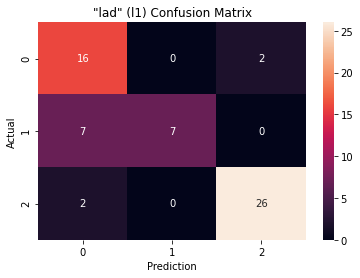

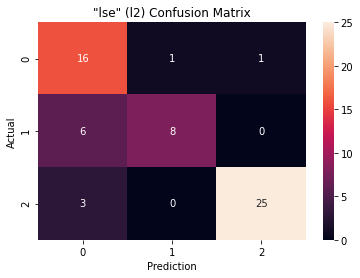

In [8]:
# confusion matrices
for func, name in functions.items():
    fig, ax = plt.subplots()
    model = nn_classifier(train_data = train_data, metric = func)
    model.predict(test_data)
    model.confuse()
    ax = sns.heatmap(model.confusion_matrix, fmt = '.3g', annot = True)
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Actual')
    ax.set_title(f'"{func}" ({name}) Confusion Matrix')
    plt.show()

For "lad" (l1): k = 7, error = 15.0%


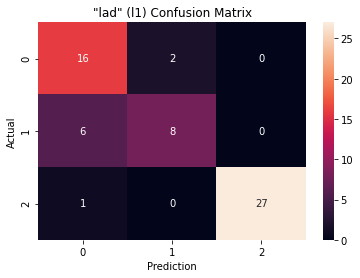

For "lse" (l2): k = 3, error = 16.67%


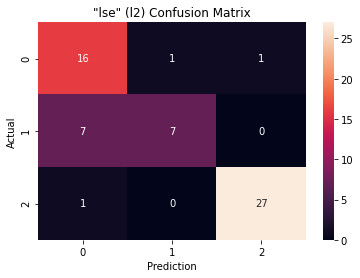

In [9]:
# optimizing neighbor count for each distance function
functions = {'lad':'l1', 'lse':'l2'}
times = []
ks = []
for func, name in functions.items():
    bucket = []
    for i in range(1, 30):
        model = nn_classifier(train_data = train_data, neighbors = i, metric = func)
        model.predict(test_data)
        model.score()
        bucket.append(model.error)
    ks.append(np.argmin(bucket)+1)
    print(f'For "{func}" ({name}): k = {np.argmin(bucket)+1}, error = {np.min(bucket)}%')
    model = nn_classifier(train_data = train_data, neighbors = np.argmin(bucket) + 1, metric = func)
    t1 = time.time()
    model.predict(test_data)
    t2 = time.time()
    times.append(t2 - t1)
    model.confuse()
    fig, ax = plt.subplots()
    ax = sns.heatmap(model.confusion_matrix, fmt = '.3g', annot = True)
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Actual')
    ax.set_title(f'"{func}" ({name}) Confusion Matrix')
    plt.show()

The optimal k values of 7 and 3 for the "lad" and "lse" nearest neighbor models dropped the error rates by 3.33% and 1.66%, respectively.

## Sklearn Comparison

As a point of comparison, the following code cell will classify the same dataset using sklearn's NearestNeighbors method.

In [10]:
# data and labels split
train_labels = train_data[:, -1]
train_data = train_data[:, :-1]
test_labels = test_data[:, -1]
test_data = test_data[:, :-1]

For "lad" metric: error = 15.0%
Time delta, percent delta scratch -> sklearn: -0.006814 seconds, -377.06%


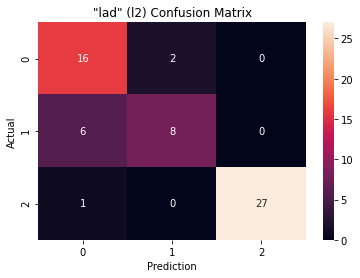

For "lse" metric: error = 16.67%
Time delta, percent delta scratch -> sklearn: -0.008642 seconds, -493.24%


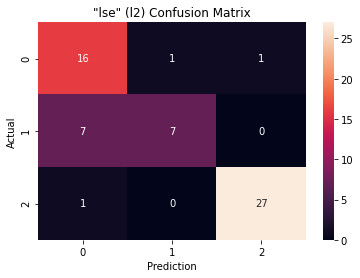

In [11]:
# nearest neighbors classifier for each distance metric
for n, p in zip([7, 3], [1, 2]):
    model = KNeighborsClassifier(n_neighbors = n, p = p)
    model.fit(train_data, train_labels)
    t1 = time.time()
    test_pred = model.predict(test_data)
    t2 = time.time()
    times.append(t2 - t1)
    error = np.sum(test_pred != test_labels)/test_labels.shape[0]
    func = list(functions.keys())[p - 1]
    print(f'For "{func}" metric: error = {round(error*100, 2)}%')
    time_delta = times[p + 1] - times[p - 1]
    print(f'Time delta, percent delta scratch -> sklearn: {round(time_delta, 6)} seconds, {round(time_delta*100/times[p + 1], 2)}%')
    confuse = confusion_matrix(test_labels, test_pred)
    fig, ax = plt.subplots()
    ax = sns.heatmap(confuse, fmt = '.3g', annot = True)
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Actual')
    ax.set_title(f'"{func}" ({name}) Confusion Matrix')
    plt.show()
    

The most notable difference between the scratch and purpose built nearest neighbor methods is the time to execute. The sklearn method consistently shows a several hundred percent improvement on my own implementation. Outside this, error rates and confusion matrics are identical (as expected). 